<a href="https://colab.research.google.com/github/laaksonenl/machine-learning/blob/master/california_housing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# California housing price prediction

The goal is to build a model to predict housing prices in California based on the California census data. This removes the current need of manual estimation by experts which time-consuming and costly.


## Problem definition

The housing price prediction is a question of supervised learning since we have all the right answers (labels) available in California census dataset.

Since the model uses multiple features (defined in the dataset), the problem is more specifically a multivariate regression problem. The goal is to create a prediction of price for any house in California. Since the result will be always real/continuous value, the task at hand is regression problem.

All the data is already available in the dataset and there's no flow of new data in the scope of this problem, so we'll move on with just plain batch learning. The dataset is small enough so there's no need to split it in order to load it into memory.

Additionally, any assumption should be listed here. For example, if the model is part of some bigger pipeline, it's necesssary to communicate with other parties related to the overall system. If the downstream system does not need exact real values, but some arbitrary price ranges, the problem might be more of classification than regression. Keep the bigger picture in mind.


## Performance metrics

For regression problems, a typical measure is Root Mean Square Error ($RMSE$).

$RMSE(\textbf{X},h) = \sqrt{\dfrac{1}{m}\Sigma^{m}_{i=1} (h(\textbf{x}^{(i)}) - y^{(i)})^2}$

where

$m$ is a number of sample instances in the dataset,

$x^{(i)}$ is the feature vector of $i$th sample,

$y^{(i)}$ is the label of the $i$th sample

$RMSE$ is the cost of the model, it's the sum of the difference between true value (label, $y$) and the value ($h(x)$) predicted by the model.

This is our initial choice of performance metric. If the data appears to contain lots of outliers, we'll consider other options which are less sensitive to outliers, for example *Mean Absolute Error*.

$MAE(\textbf{X},h) = {\dfrac{1}{m}\Sigma^{m}_{i=1} \mid{h(\textbf{x}^{(i)}) - y^{(i)}}}\mid$

The sensitivity of *RMSE* for outliers come from its *degree of 2*. Outliers cause a greater difference between the prediction (*h(x)*) and true value (*y*).
Since the model tries to generalize the problem, the prediction based on the outlier is more off than with the regular samples.

Now, when this difference (or distance) between prediction and true value is high and it's further square in *RMSE* the bigger difference have more impact on the overall error value. This results in higher error values when there's lots of outliers in the data.

With *MAE*, the degree is 1 so the impact of the distance is linear so outliers won't affect that the final error value.

## Exploratory data analysis

The California housing dataset is acquired from https://www.kaggle.com/camnugent/california-housing-prices

The page also contains full description of the features included in the dataset.


In [1]:
! pip install -q kaggle
from google.colab import files

# Select your exported Kaggle API json file
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
! kaggle datasets download -d 'camnugent/california-housing-prices'

  0% 0.00/400k [00:00<?, ?B/s]
100% 400k/400k [00:00<00:00, 54.5MB/s]


In [3]:
%%bash
mkdir -p /content/data
unzip /content/california-housing-prices.zip -d /content/data

Archive:  /content/california-housing-prices.zip
  inflating: /content/data/housing.csv  


In [4]:
import pandas as pd

In [5]:
def load_housing_data(csv_path):
  return pd.read_csv(csv_path)

In [6]:
housing = load_housing_data('/content/data/housing.csv')

In [7]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


- 20640 total samples
- *total_bedrooms* is missing some data, only 20433 values out of 20640
- All float values except *ocean_proximity* which seems to be a categorical text value

In [9]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [10]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


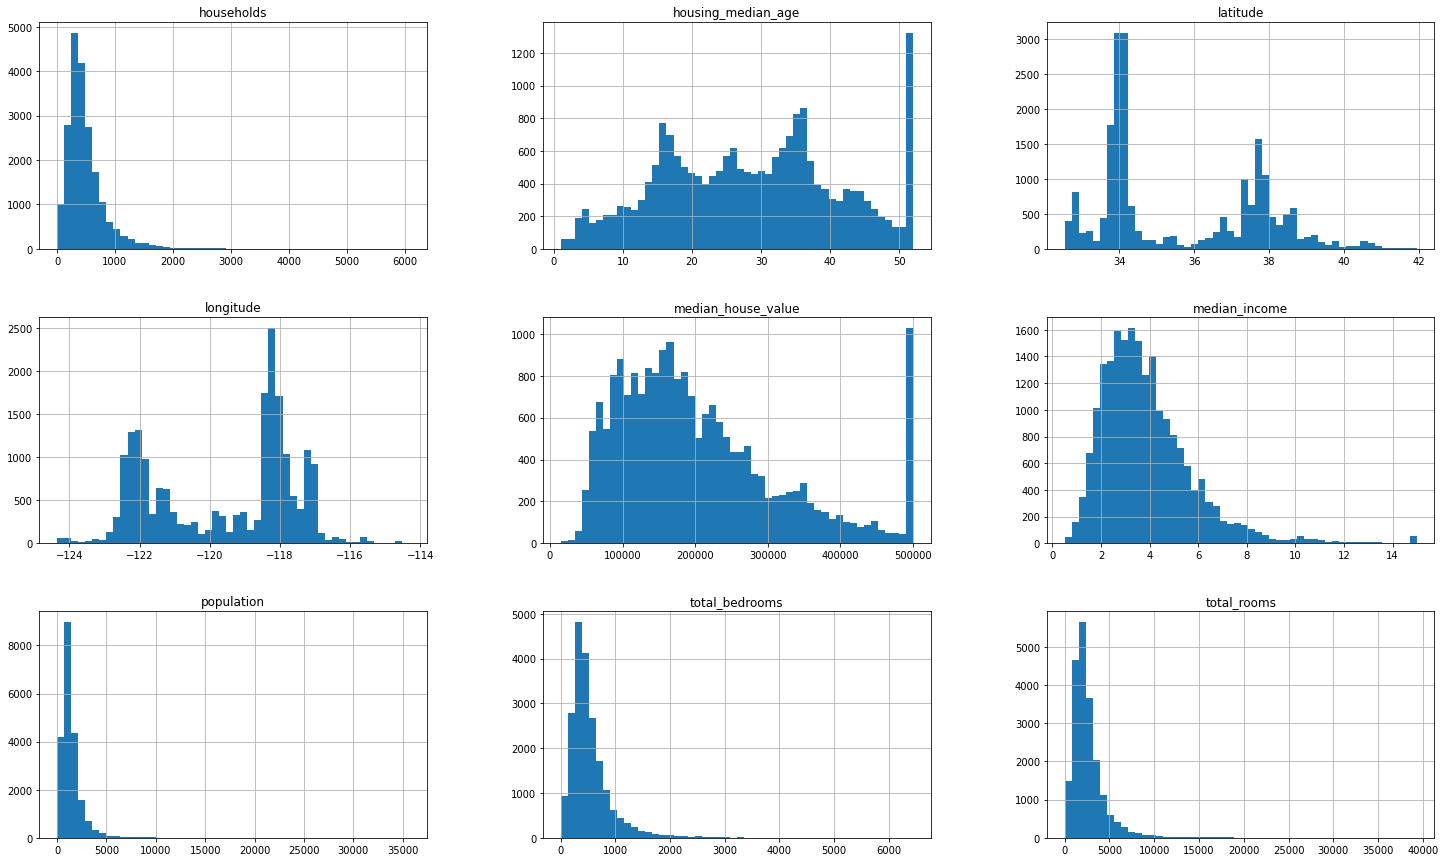

In [11]:
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(25,15))
plt.show()

- *median_income* is not in US dollars, it has been preprocessed some way (scaled to 0.5 - 15)
- *housing_median_age* is capped (see the value count going up in the sky after 50)
- *median_house_value* is also capped at 500 000, this might be problematic since this attribute is **the label** of this prediction problem
  - May need to remove the capped values from the dataset
  - Alternatively, collect the real values for the capped houses
- Looking at the min and max values of the attributes, they are in very different scales (a need for feature scaling)
- Tail-heavy histograms:
  - Some algorithm struggle to find patterns with skewed distributions, may need to engineer the distributions to be more bell-shaped

### Split the data

The test sets needs to stay the same between runs or if the dataset is updated.



In [12]:
import hashlib
import numpy as np

def test_set_check(identifier, test_ratio, hash):
  # Calculate hash for the id
  # Take the last byte of it and select it to test set if the value is
  # lower than 256 * test portion (i.e. 256 * 20% = 51)
  return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

In [13]:
def split_train_test(data, test_ratio, id_column, hash=hashlib.md5):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
  return data[~in_test_set], data[in_test_set]

In [14]:
# There's no id attribute so create one from the most stable and unique attributes
# You could use index too, but then new data must always be appended to the end of the dataset
# and row deletion cannot be run.

# If this is not a problem for you, you could just use sklearn train_test_split
# from sklearn.model_selection import train_test_split
# train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["id"] = housing["longitude"] * 1000 + housing["latitude"]

train_set, test_set = split_train_test(housing, 0.2, "id")
print(len(train_set), "train samples,", len(test_set), "test samples")

16267 train samples, 4373 test samples


### Stratified sampling

A sampling method where population is split in homogenous subgroups by some common characteristics called strata.
From each strata, a right number of samples is pulled to guarantee that the samples represent the population.

This way a sampling bias is avoided.

Each strata should have enough samples in order to avoid sampling noise.

In [15]:
# Limit income category count by dividing income by 1.5
# Too many categories means less samples in each category, introducing us sampling noise
housing["income_category"] = np.ceil(housing["median_income"] / 1.5)
housing["income_category"].where(housing["median_income"] < 5, 5.0, inplace=True)

# Another way to bin values in intervals
"""
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])
"""

'\nhousing["income_cat"] = pd.cut(housing["median_income"],\n                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],\n                               labels=[1, 2, 3, 4, 5])\n'

Text(0.5, 1.0, 'Created Income categories')

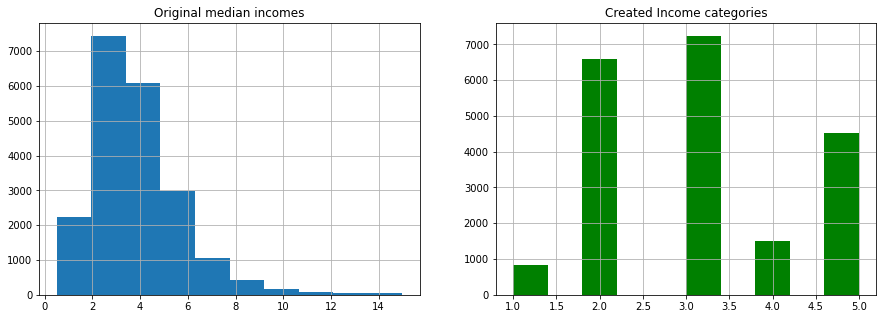

In [16]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

housing["median_income"].hist(ax=axes[0]).set_title('Original median incomes')
housing["income_category"].hist(ax=axes[1], color='green').set_title('Created Income categories')

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(housing, housing["income_category"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
from sklearn.model_selection import train_test_split

def income_cat_proportions(data):
    return data["income_category"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()

compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [19]:
compare_props

,Overall,Stratified,Random,Rand. %error,Strat. %error
1.0,0.039826,0.039729,0.040213,0.973236,-0.243309
2.0,0.318847,0.318798,0.324370,1.732260,-0.015195
3.0,0.350581,0.350533,0.358527,2.266446,-0.013820
4.0,0.072287,0.072432,0.070494,-2.479893,0.201072
5.0,0.218459,0.218508,0.206395,-5.522289,0.022178


In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_category", axis=1, inplace=True)

## Data visualizations for insights

Explore the data further to get some insight about what it is we are deal with here.

Do exploration only with training set, test set needs to be untouchable.
If training set is huge, it's better to take a portion of it and explore with that ("exploration set").


In [21]:
# Take a copy so the data can be wrangled safely during the exploration
housing = strat_train_set.copy()

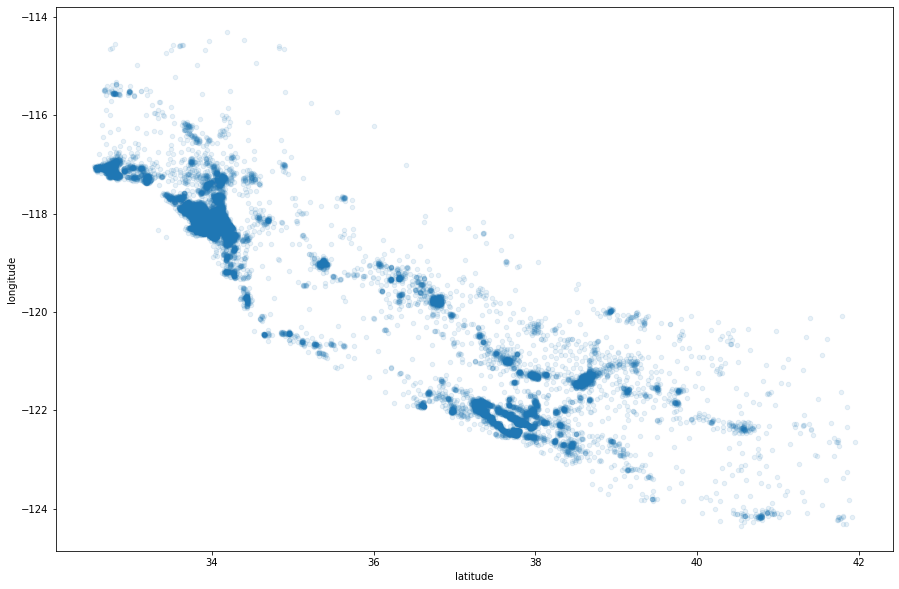

In [22]:
# Set alpha so the high density areas can be detected
housing.plot(kind="scatter", x="latitude", y="longitude", figsize=(15,10), alpha=0.1)

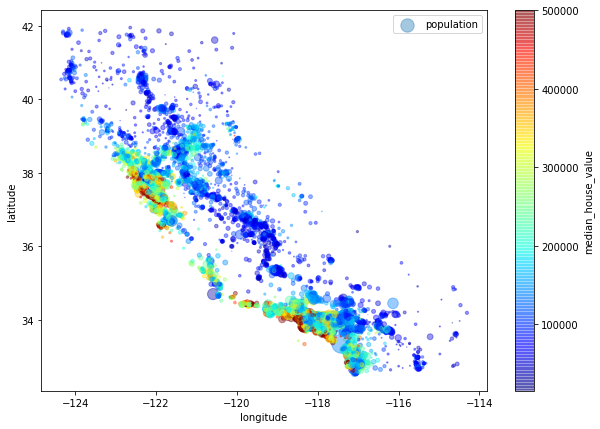

In [23]:
# color map "jet" = low (blue) to high (red)
# s = dot size
# c = dot color
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
    s=housing["population"]/100, label="population", figsize=(10,7),
    c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
    sharex=False)

In [24]:
# Check correlation (Pearson's r)

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687752
total_rooms           0.136422
housing_median_age    0.106985
households            0.066340
total_bedrooms        0.050081
population           -0.024622
longitude            -0.047586
id                   -0.047786
latitude             -0.142814
Name: median_house_value, dtype: float64

Strong correlation with income, the higher the income, the higher the house value.

Also, latitude correlates negatively meaning that the norther we go (latitude grows, the lower the house value goes).

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc5c45a4550>,
      dtype=object)

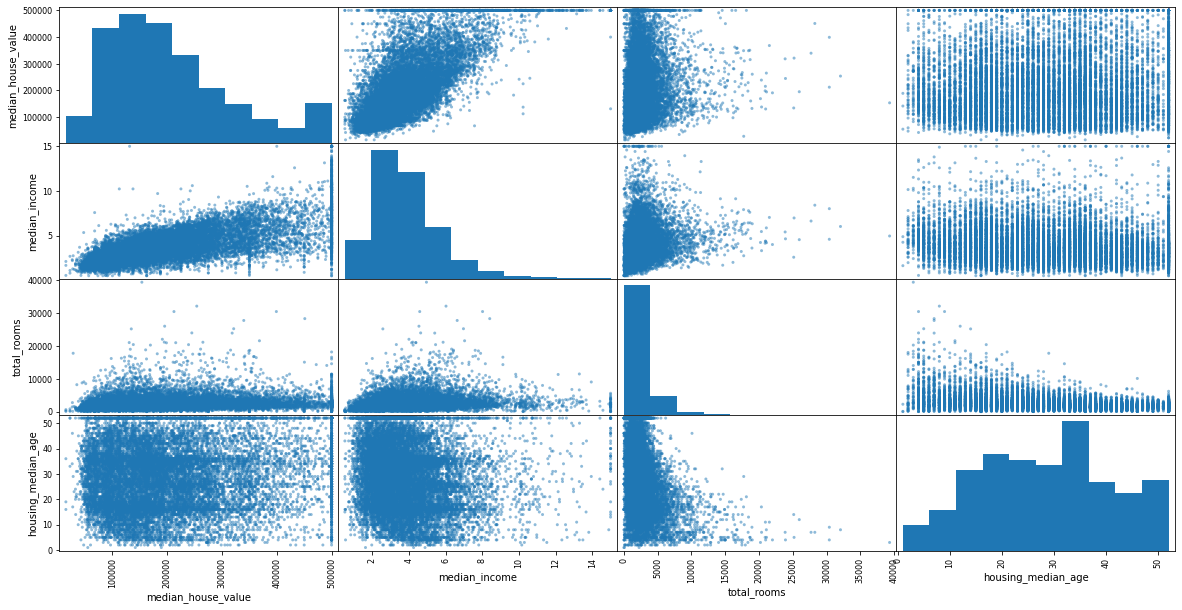

In [25]:
from pandas.plotting import scatter_matrix

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

scatter_matrix(housing[attributes], figsize=(20, 10))

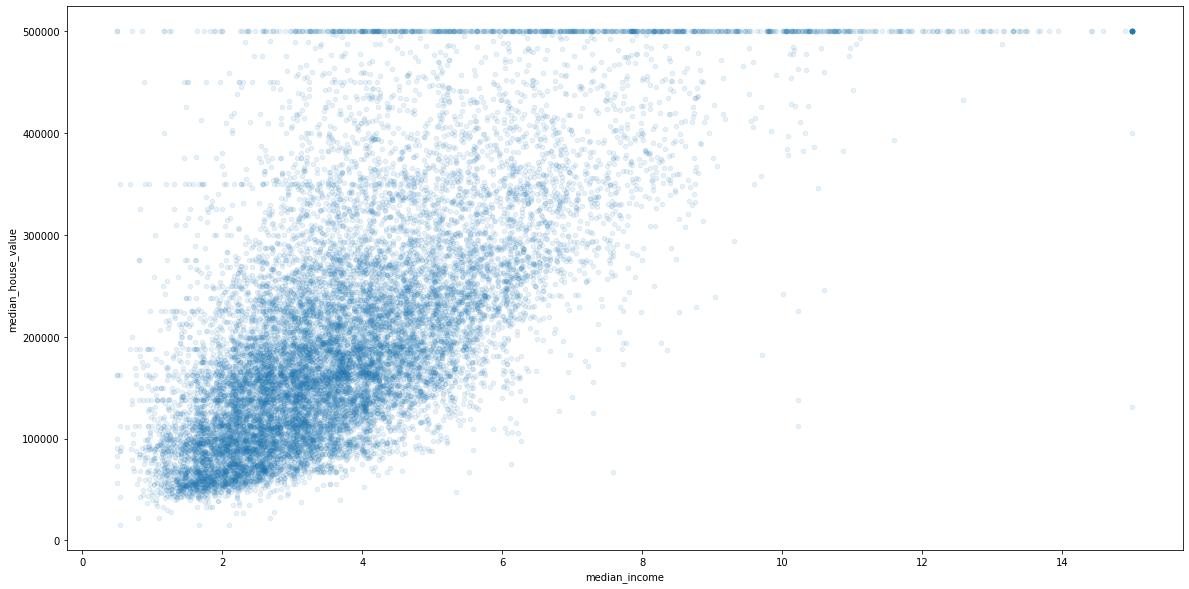

In [26]:
housing.plot(kind="scatter", x="median_income", y="median_house_value", alpha=0.1, figsize=(20,10))

- Upward trend implies strong positive correlation between income and house value
- The price cap can be seen as straight line on the top
- Other non-obvious lines at 450k, 350k etc
  - Maybe remove them so the model won't reproduce them (if infact they're not valid trends)


In [27]:
# Try other, more interesting combinations which might show stronger correlations
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["bedrooms_per_household"] = housing["total_bedrooms"]/housing["households"]
housing["population_per_household"] = housing["population"]/housing["households"]

corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687752
rooms_per_household         0.145300
total_rooms                 0.136422
housing_median_age          0.106985
households                  0.066340
total_bedrooms              0.050081
population_per_household   -0.022435
population                 -0.024622
bedrooms_per_household     -0.043514
longitude                  -0.047586
id                         -0.047786
latitude                   -0.142814
bedrooms_per_room          -0.258861
Name: median_house_value, dtype: float64

In [28]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

# Data cleaning

Handle missing *total_bedrooms* samples, options are:
- Drop rows with missing value
- Drop the whole attribute (if there's lots of missing data)
- Impute the values with some statistic figure



In [29]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

# Imputer works only for numerical data, drop categorical attribute
housing_num = housing.drop("ocean_proximity", axis=1)

In [30]:
# Calculates median for each attribute and stores them in "statistics_" variable
imputer.fit(housing_num)

imputer.statistics_

array([-1.18520000e+02,  3.42600000e+01,  2.90000000e+01,  2.12050000e+03,
        4.33000000e+02,  1.16400000e+03,  4.08000000e+02,  3.54090000e+00,
       -1.18485625e+05])

In [31]:
X = imputer.transform(housing_num)

In [32]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns)
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16512 entries, 0 to 16511
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   id                  16512 non-null  float64
dtypes: float64(9)
memory usage: 1.1 MB


Machine learing algos prefer numbers over text, convert text attributes (ocean_proximity) to numerical values.

In [33]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat) # Same as calling fit() and then transform()

proximity_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
print(proximity_mapping)

{'<1H OCEAN': 0, 'INLAND': 1, 'ISLAND': 2, 'NEAR BAY': 3, 'NEAR OCEAN': 4}


Encoding labels directly to numbers arises another problem.
ML algos will assume that numbers close to each other are more similar even though that's not the case. For example, OCEAN (0) and NEAR OCEAN (4) are semantically more similar than INLAND (1) and ISLAND (2) but arithmetically they are far away from each other.

This issue can be solved by creating a binary attribute for each category aka "one-hot encoding"

In [34]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
# Expects 2D array, reshape the parameter
# The result will be sparse matrix instead of numpy array
# This is because there'll thousands columns but only 1 per row, rest are zeros
# Sparse matrix stores only the locations of the 1s
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1, 1))

# Another way of doing the same for both category -> int and int -> category
# from sklearn.preprocessing import LabelBinarizer
# encoder = LabelBinarizer()
# 1hot = encoder.fit_transform(housing_cat, sparse_output=True)

## Custom transformers
For custom cleanup and combination operations


In [35]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## Feature scaling

**IMPORTANT!**

Fit scalers only to training data, not the full dataset
It's important not to leak any information from the test set in order to get honest performance metric for your model

Remember this principle:

**Any thing you learn, must be learned from the model's training data**

Min-max scaling (normalization): rescale to range from 0 to 1
- Outliers spread the min max range, crushing the values in-between

  $X' = \frac{X - X_{min}}{X_{max} - X_{min}}$

Standardization:
- Zero mean
- Unit variance
- Not bound to any range
  - Problematic for neural networks expecting values to be in 0 - 1
  - Much less affected by outliers

  $X' = \frac{X - \mu}{\sigma}$

## Building a pipeline

Create a complete pipeline from the previous data transformation steps

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# All but last must be transformers (fit_transform method)
# Names can be anything
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [37]:
# Sklearn knows nothing about Pandas DataFrame, it accepts only numpy arrays
# Create a custom transformer for this conversion

from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

# FeatureUnion applies different transformers to the WHOLE of the input data
# ColumnTransformer applies different transformers to different SUBSETS of the whole input data
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

# Runs both num and cat pipelines in parallel
housing_prepared = full_pipeline.fit_transform(housing)

## Train a model

In [38]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [39]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

# Remember to transform the input since the model is trained with transformed input
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [397871.   413171.75 229299.25  96521.   289577.25]


In [40]:
print("Labels:", list(some_labels))

Labels: [500001.0, 500001.0, 174200.0, 91400.0, 434000.0]


In [41]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68498.07786699798

In [42]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49365.23884144864

Huge error with predictions on training data implies that our model is underfitting. The model behaves badly even with the data it has seen.

The features do not provide enough information in order to make good predictions.

To fix underfitting:
- Create more meaningful features
- Use more powerful model
- Easen up regularization

The model is not regularized, try different model

In [43]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=42, splitter='best')

In [44]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

Looks like the model did overfit badly, let's use better evaluation technique

## Cross-validation

Split training set in K subsets (folds). Train K different models by choosing one fold to be the evaluation set and the remaining (K - 1) sets are used for training. Each model choose different set to be the evaluation set.

As a result there's K different scores.

In [45]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)

# Sklearn convention: higher is better
# With costs, sklean negates them (higher cost -> lower number)
# Remember to negate them back to positive
tree_rmse_scores = np.sqrt(-scores)

In [46]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [73134.70856836 70555.38768854 72447.46619955 69677.69058683
 74190.55399881 73836.0372155  69358.38951013 67686.04348861
 70744.07853588 69929.28808423]
Mean: 71155.96438764464
Standard deviation: 2036.3429703613244


Mean cost is higher than with linear regression, this proves the suspicion about overfitting right.

Notice that cross-validation gives us standard deviation so we can see how reliable the cost value actually is.

In [47]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(n_estimators=100, random_state=42)
forest_reg.fit(housing_prepared, housing_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [48]:
housing_predictions = forest_reg.predict(housing_prepared)
forest_mse = mean_squared_error(housing_labels, housing_predictions)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

18884.563848322166

In [ ]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                                scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Training set cost: 18884
Validation set cost (mean): 50678

Because the cost on training set is much lower than on validation set, this means that the model still overfits.

The model could be optimized more with regularization, but it's  usually better to experiment with different models before trying to deep-optimize a single model.

You should save every model you experiment with so you can come back to them later.

In [ ]:
# You can also use Python pickle module to save the model
# from sklearn.externals import joblib
# joblib.dump(model, "model.pkl")
# model_loaded = joblib.load("model.pkl")

## Fine-tuning model

Finding an optimal combination of hyperparameters

Instead of manually trying the parameters, let's use grid search which is based on the cross validation. It tries different ranges for each model and finds the best one.

### Grid search

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# All in all (12 + 6 combinations) * 5 cross validation folds

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

grid_search.best_params_
grid_search.best_estimator_

# If grid search is initialized with refit=True, once the best estimator is found
# it retrains it on the whole training set

# Evaluation scores
grid_search.cv_results_

### Other methods

#### Randomized search
If the hyperparameter search space is large, it is preferable to use randomized search. You can set the max iteration number and the algorithm will try 1000 different value for each feature.


#### Ensemble method
Group the models which perform the best. As a group they will work better.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_reg = RandomForestRegressor(random_state=42)

rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)

In [ ]:
cvres = rnd_search.cv_results_
pd.DataFrame(rnd_search.cv_results_)

In [ ]:
rnd_search.best_params_

### Analyzing the best models
- Some models can list the feature importance for the features they're using
- Less useful features can be dropped which may also help with overfitting

In [ ]:
feature_importances = rnd_search.best_estimator_.feature_importances_

extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]

cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attribs = list(cat_encoder.categories_[0])
attributes = num_attribs + extra_attribs + cat_one_hot_attribs

sorted(zip(feature_importances, attributes), reverse=True)

## Evalution on the test set



In [ ]:
final_model = rnd_search.best_estimator_

X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

# Remember to transform the inputs (not fit_transform)
X_test_prepared = full_pipeline.transform(X_test)
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

In [ ]:
# Calculate confidence interval for the RMSE error
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test) ** 2

# T-test
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))

In [ ]:

m = len(squared_errors)
mean = squared_errors.mean()
tscore = stats.t.ppf((1 - confidence) / 2, df=m - 1)
tmargin = tscore * squared_errors.std(ddof=1) / np.sqrt(m)
np.sqrt(mean - tmargin), np.sqrt(mean + tmargin)

In [ ]:
# Full pipeline with both transform and prediction
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)